In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil

In [8]:
noisy_voice = np.load("/content/drive/MyDrive/npy/noisy_voice_amp_db.npy")
voice = np.load("/content/drive/MyDrive/npy/voice_amp_db.npy")
noise = noisy_voice-voice


# Shape of noisy voice data
print(noisy_voice.shape)
# Shape of noise data
print(noise.shape)

(500, 128, 128)
(500, 128, 128)


In [ ]:
mkdir weights

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam

def cnn_model(input_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(128 * 128 * 1, activation='sigmoid'))  # Adjust the output shape to match the label shape

    # Reshape output to match label shape
    model.add(Reshape((128, 128, 1)))

    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Set learning rate here
        loss='mean_squared_error',  # Use mean squared error loss
        metrics=['mae']  # Mean Absolute Error as a metric
    )
    return model

# Assuming input shape is (128, 128, 1) based on the provided shapes of X_train and X_test
input_shape = (128, 128, 1)

# Create the CNN model
model = cnn_model(input_shape)

# Display model summary
#model.summary()


In [10]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec
def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

In [11]:

def plot_accuracy(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Function to plot predicted vs target spectrograms
def plot_spectrograms(y_val, y_pred):
    num_samples_to_visualize = 3
    sample_indices = np.random.choice(y_val.shape[0], num_samples_to_visualize, replace=False)

    for idx in sample_indices:
        plt.figure(figsize=(12, 6))

        # Display target spectrogram
        plt.subplot(1, 2, 1)
        plt.imshow(y_val[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Target Spectrogram - Sample {idx}")

        # Display predicted spectrogram
        plt.subplot(1, 2, 2)
        plt.imshow(y_pred[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Predicted Spectrogram - Sample {idx}")

        plt.tight_layout()
        plt.show()


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 0.0694 - mae: 0.1841
Epoch 1: val_loss improved from inf to 0.01874, saving model to weights/model_cnn_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 49s 1s/step - loss: 0.0694 - mae: 0.1841 - val_loss: 0.0187 - val_mae: 0.1109
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.0190 - mae: 0.1124
Epoch 2: val_loss did not improve from 0.01874
2/2 [==============================] - 1s 395ms/step
Mean Squared Error (MSE): 0.018736849576048792
target [[ 0.18774065  0.28875344  0.43707731 ... -0.07317073 -0.07317073
  -0.07077258]
 [-0.01338261  0.01694826  0.14271366 ... -0.07317073 -0.07317073
  -0.02948164]
 [ 0.06793997  0.2077591   0.45181758 ... -0.07317073 -0.07317073
  -0.02673654]
 ...
 [-0.06305292  0.16141482  0.22704871 ... -0.07317073 -0.07317073
  -0.10739578]
 [ 0.17869795  0.20224363  0.16073095 ... -0.07317073 -0.07317073
  -0.11532045]
 [ 0.10277149  0.03109675 -0.18952562 ... -0.07317073 -0.07317073
  -0.05462423]]
prediction [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0

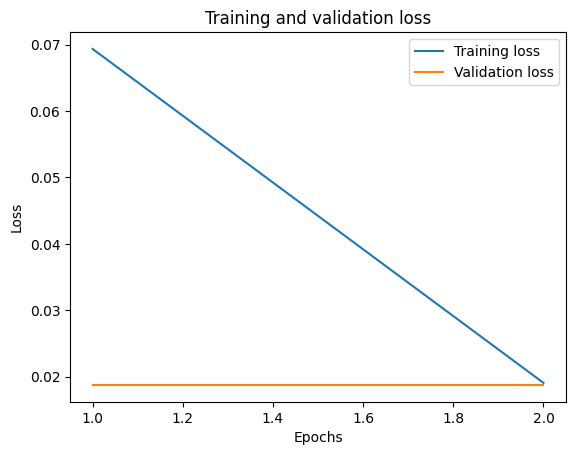

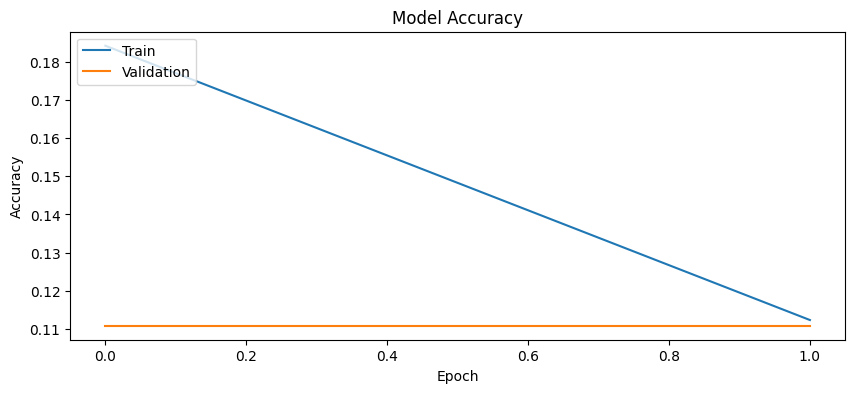

2/2 [==============================] - 1s 418ms/step


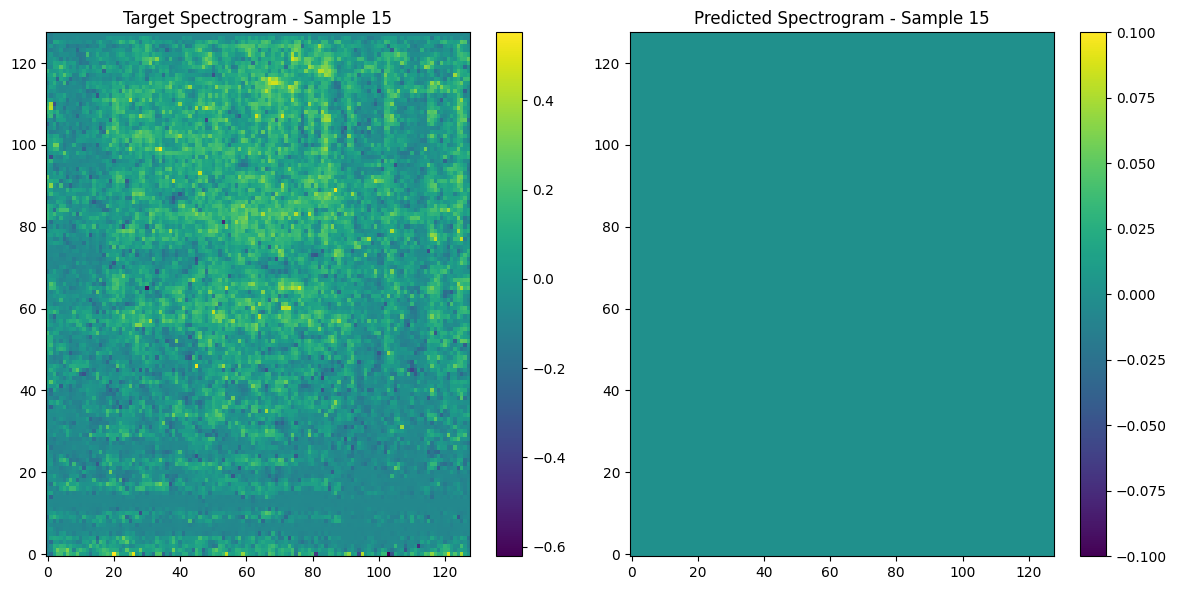

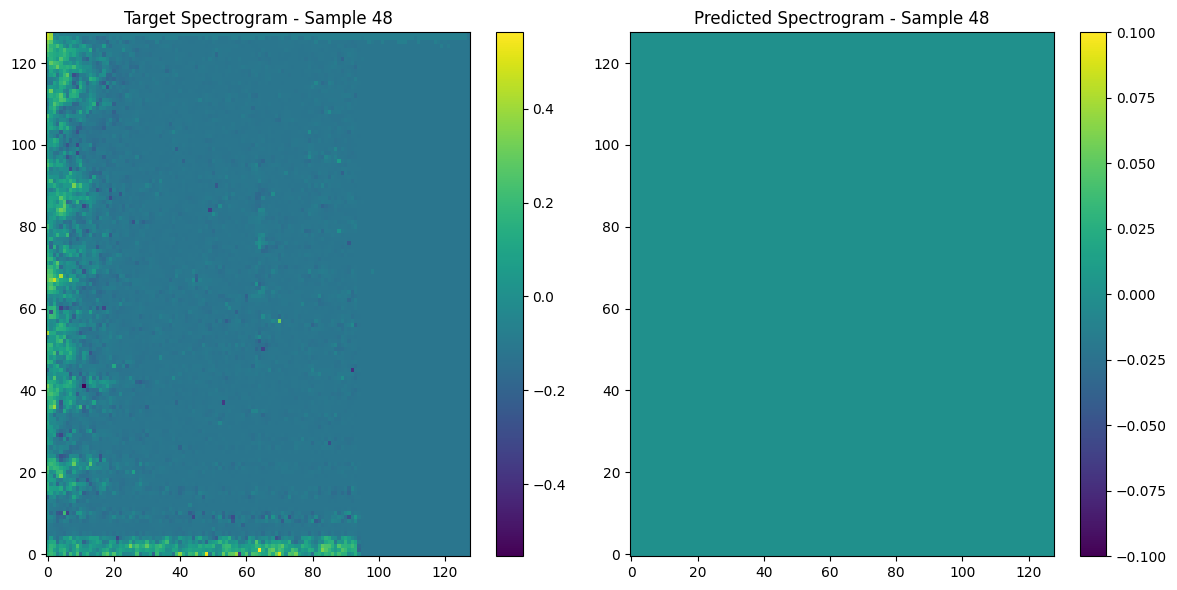

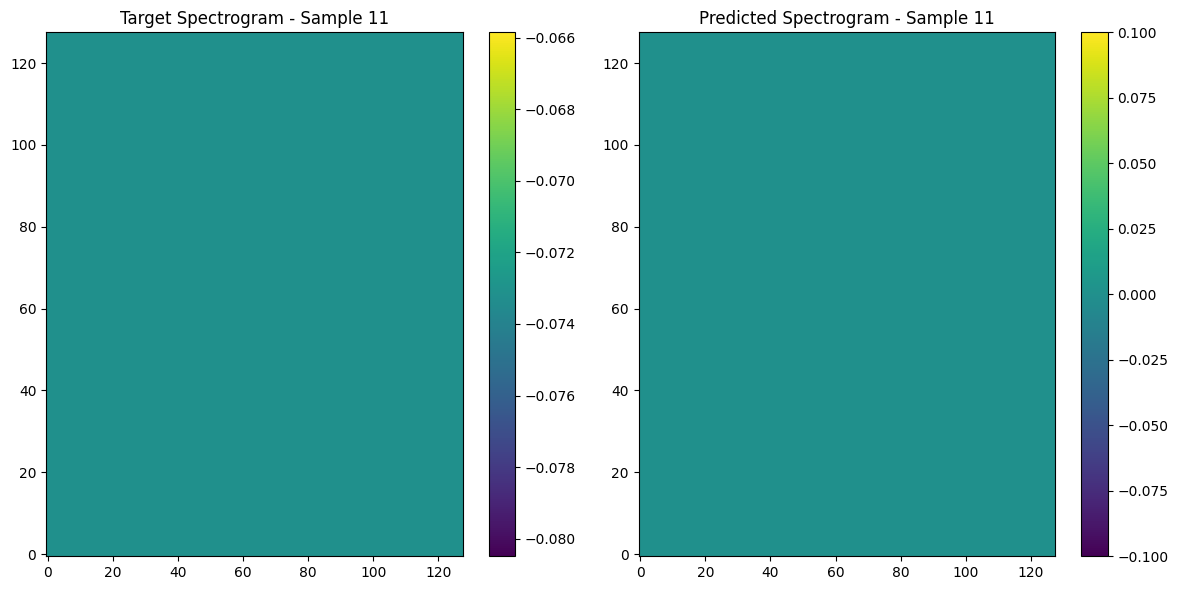

In [16]:
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error

import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil
import matplotlib.pyplot as plt

def training_cnn(path_save_spectrogram, weights_path, epochs, batch_size):
    # Load noisy voice & clean voice spectrograms created by data_creation mode
    X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
    X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")

    # Model of noise to predict
    X_ou = X_in - X_ou

    # Check distribution
    # print(stats.describe(X_in.reshape(-1,1)))
    # print(stats.describe(X_ou.reshape(-1,1)))

    # Rescale between -1 and 1
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    # Check shape of spectrograms
    # print(X_in.shape)
    # print(X_ou.shape)
    # Check new distribution
    # print(stats.describe(X_in.reshape(-1,1)))
   #  print(stats.describe(X_ou.reshape(-1,1)))

    # Reshape for training
    X_in = X_in[:, :, :]
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_ou = X_ou[:, :, :]
    X_ou = X_ou.reshape(X_ou.shape[0], X_ou.shape[1], X_ou.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    # print("X_train shape:", X_train.shape)
    # print("X_test shape:", X_test.shape)
    # print("y_train shape:", y_train.shape)
    # print("y_test shape:", y_test.shape)

    # Create CNN model
    model = cnn_model(X_train.shape[1:])

    # Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path + '/model_cnn_best.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

    #model.summary()

    # Training
    history = model.fit(X_train, y_train, epochs=2, batch_size=10, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))

    # Saving Model
    model.save_weights(weights_path + '/model_cnn_final.h5')

    # Compute MSE and SNR
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test.reshape(y_test.shape[0], -1), y_pred.reshape(y_pred.shape[0], -1))
    print(f"Mean Squared Error (MSE): {mse}")

    def compute_snr(target, prediction):
        noise = target - prediction
        snr = 10 * np.log10(np.mean(target**2) / np.mean(noise**2))
        return snr
    print('target',y_test.reshape(y_test.shape[0], -1))
    print('prediction',y_pred.reshape(y_pred.shape[0], -1))
    snr = compute_snr(y_test.reshape(y_test.shape[0], -1), y_pred.reshape(y_pred.shape[0], -1))
    print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

    # Plot training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(loss) + 1)

    plt.plot(epochs_range, loss, label='Training loss')
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plot_accuracy(history)

    # Plot predicted vs target spectrograms
    y_pred = model.predict(X_test)
    plot_spectrograms(y_test, y_pred)

# Example usage:
# Assuming you have the necessary data files and directories set up

# Set the paths and parameters
path_save_spectrogram = "/content/drive/MyDrive/npy/";
weights_path = 'weights/'
epochs = 20
batch_size = 10

# Call the training function
training_cnn(path_save_spectrogram, weights_path, epochs, batch_size)

In [ ]:
#Helper Functions
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct


def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft):
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):
        # Reshape magnitude and phase arrays to have compatible shapes
        mag_db = m_mag_db[i].reshape(-1, 1)  # Reshape to a column vector
        phase = m_phase[i].reshape(-1, 1)    # Reshape to a column vector

        # Reconstruct audio from magnitude and phase
        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, mag_db, phase)

        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)


def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

from skimage.transform import resize

def resize_or_crop(spectrogram, target_shape):
    """
    Resize or crop the spectrogram to match the target shape.

    Parameters:
        spectrogram (numpy.ndarray): The input spectrogram.
        target_shape (tuple): The target shape (height, width) of the spectrogram.

    Returns:
        numpy.ndarray: The resized or cropped spectrogram.
    """
    # Resize the spectrogram to the target shape using bilinear interpolation
    resized_spectrogram = resize(spectrogram, target_shape, mode='reflect', anti_aliasing=True)

    return resized_spectrogram


In [ ]:
import numpy as np
import librosa

# Load the input audio file
input_audio_path = "noise_long.wav"  # Replace with the path to your input audio file
input_audio, sr = librosa.load(input_audio_path, sr=None)

# Convert the input audio to a spectrogram
frame_length = 2048  # Example value, replace with actual frame length used for spectrogram calculation
hop_length_fft = 512  # Example value, replace with actual hop length used for spectrogram calculation
stft_audio = librosa.stft(input_audio, n_fft=frame_length, hop_length=hop_length_fft)
stft_magnitude, stft_phase = librosa.magphase(stft_audio)
stft_magnitude_db = librosa.amplitude_to_db(np.abs(stft_magnitude), ref=np.max)

stft_magnitude_db_resized = resize_or_crop(stft_magnitude_db, target_shape=(128, 128))

# Scale the spectrogram between -1 and 1
scaled_input = (stft_magnitude_db_resized - 6) / 82  # Apply inverse scaling used during training
print("Shape of scaled_input:", scaled_input.shape)

print("Shape of scaled_input:", scaled_input.reshape(1, *scaled_input.shape))
# Assuming you already have a trained model, use it to predict the noise
predicted_noise = model.predict(scaled_input.reshape(1, *scaled_input.shape))
# Step 6: Predicted Noise (already performed)

# Step 7: Rescale Back the Noise
rescaled_noise = inv_scaled_ou(predicted_noise)  # Assume this function is defined elsewhere

# Step 8: Input Audio - Output
clean_audio = input_audio - rescaled_noise

# Step 9: Matrix Spectrogram to Numpy Audio
clean_audio_np = matrix_spectrogram_to_numpy_audio(clean_audio, stft_phase, frame_length, hop_length_fft)

# Step 10: Output Audio
output_audio_path = "output_audio.wav"  # Replace with desired output audio file path
librosa.output.write_wav(output_audio_path, clean_audio_np, sr)

print("Output audio saved successfully.")
